# Duds During Darden's Duration:
## Anomaly Detection in Access Logs
#### Kwame V. Taylor

Project Description Here.

Info on cohorts can be found in ```cohorts.csv```.

### Imports

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn import metrics

from scipy.stats import entropy

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates #to format dates on our plots
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

# default viz size settings
plt.rc('figure', figsize=(14, 9))
plt.rc('font', size=15)

# This is to make sure matplotlib doesn't throw the following error:
# The next line fixes "TypeError: float() argument must be a string or a number, not 'Timestamp' matplotlib"
pd.plotting.register_matplotlib_converters()

# importing GeoIP database for IP geolocation
import geoip2.database
reader = geoip2.database.Reader('GeoLite2City/GeoLite2-City.mmdb')

# import system to check errors
import sys

### Acquire

In [2]:
colnames = ['date', 'timestamp', 'request_method', 'user_id', 'cohort_id', 'ip']

df = pd.read_csv('anonymized-curriculum-access.txt', header=None, index_col=False,
                 names=colnames, delim_whitespace=True, na_values='"-"')
#                 usecols=[0, 1, 2, 5])
df.head()

,date,timestamp,request_method,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61


### Prepare

In [55]:
#drop user_id as it's useless
df = df.drop(columns=['user_id'])

In [3]:
# merge date and timestamp
df["ds"] = df["date"] +" "+ df["timestamp"]
df.head()

,date,timestamp,request_method,user_id,cohort_id,ip,ds
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,2018-01-26 09:55:03
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24


In [4]:
# drop date and timestamp
df = df.drop(columns=['date', 'timestamp'])
df.head()

,request_method,user_id,cohort_id,ip,ds
0,/,1,8,97.105.19.61,2018-01-26 09:55:03
1,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02
2,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05
3,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06
4,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24


In [5]:
# convert date column to datetime type
df.ds = pd.to_datetime(df.ds)
df.dtypes

request_method            object
user_id                    int64
cohort_id                 object
ip                        object
ds                datetime64[ns]
dtype: object

In [6]:
# set ds as index and sort
# this is a very important step!
df = df.set_index('ds').sort_index()
df.head()

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61


In [7]:
df.shape

(719459, 4)

In [8]:
df.request_method.value_counts()

/                                        40122
search/search_index.json                 15393
javascript-i                             14551
toc                                      14018
java-iii                                 10835
                                         ...  
interview_questions                          1
10.02.04_EntityLabeling.md                   1
4-stats/2.2-probability_distributions        1
examples/css//logincss                       1
register.                                    1
Name: request_method, Length: 2154, dtype: int64

In [9]:
df.ip.value_counts()

97.105.19.58       268648
97.105.19.61        60530
192.171.117.210      8896
71.150.217.33        4919
12.106.208.194       4262
                    ...  
184.226.32.25           1
107.77.221.76           1
99.203.26.61            1
136.50.24.156           1
108.11.6.201            1
Name: ip, Length: 4064, dtype: int64

In [10]:
df.cohort_id.nunique()

386

Some IP addresses accidentally got put in the ```cohort_id``` column, so I'm going to drop those rows.

In [11]:
df = df.drop(df[df.cohort_id.str.len() > 4].index)
df

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61
...,...,...,...,...
2020-11-02 16:48:13,javascript-i/coffee-project,763,62,107.192.148.199
2020-11-02 16:48:17,javascript-i/mapbox-api,771,62,172.125.226.175
2020-11-02 16:48:18,javascript-i/coffee-project,771,62,172.125.226.175


**Drop nulls**

In [12]:
df.isna().sum()

request_method      0
user_id             0
cohort_id         420
ip                  0
dtype: int64

In [13]:
df = df.dropna()

I noticed there are some requests that are just ```/```. In the interest of time, I am choosing to just drop those rows for now, as I didn't see any pattern to the distrubution of them and assume it's something to do with the syntax reading read in wrong or there being missing data in the raw data file I imported.

**Drop bad request_methods**

In [14]:
# there are over 10,000 of these '/' requests
df.groupby(['request_method']).filter(lambda x : len(x)>10000).head(3)

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:55:03,/,1,8,97.105.19.61
2018-01-26 10:00:37,/,6,22,97.105.19.61
2018-01-26 10:00:39,javascript-i,6,22,97.105.19.61


In [15]:
df = df.drop(df[df.request_method.str.len() < 2].index)
df.head()

,request_method,user_id,cohort_id,ip
ds,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61


**Split IP address into network and host**
 * **Reference**: https://docs.oracle.com/cd/E19504-01/802-5753/planning3-18471/index.html

In [16]:
df[['network1','network2', 'host1', 'host2']] = df.ip.str.split(".",expand=True)
df.head()

,request_method,user_id,cohort_id,ip,network1,network2,host1,host2
ds,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97,105,19,61
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97,105,19,61
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,97,105,19,61


In [17]:
df['network'] = df['network1'] + df['network2']
df['host'] = df['host1'] + df['host2']
df.head()

,request_method,user_id,cohort_id,ip,network1,network2,host1,host2,network,host
ds,,,,,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97,105,19,61,97105,1961
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,97,105,19,61,97105,1961


**I notice that there is at least one instance of a different user_id under the same exact IP address. Might be a typo, or just something I don't understand about IP addresses.**

In [18]:
df = df.drop(columns=['network1', 'network2', 'host1', 'host2'])
df.head()

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2018-01-26 09:56:02,java-ii,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,97105,1961
2018-01-26 09:56:24,javascript-i/conditionals,2,22,97.105.19.61,97105,1961
2018-01-26 09:56:41,javascript-i/loops,2,22,97.105.19.61,97105,1961


In [19]:
df.network.nunique()

700

In [20]:
df.host.nunique()

3727

### Explore & Feature Engineering

In [21]:
# create dataframe out of value counts
ip_counts = pd.DataFrame(df.ip.value_counts()).reset_index()

# rename columns
ip_counts.columns=['ip', 'event_count']

# get the number of ip addresses seen 1, or 2, or 11,998 times. 
ip_counts.groupby(['event_count']).count()

,ip
event_count,
1,537
2,511
3,313
4,238
5,184
...,...
4077,1
4590,1
8447,1


In [22]:
# pass the entropy function an array-like object of counts. 
entropy(ip_counts.event_count)

4.149481083203116

**Make darden_df for just dates from Darden cohort**

In [23]:
df.tail(2)

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-11-02 16:48:28,javascript-i/bom-and-dom/bom,771,62,172.125.226.175,172125,226175
2020-11-02 16:48:47,javascript-i/bom-and-dom/bom,763,62,107.192.148.199,107192,148199


In [24]:
darden_df = df.loc['2020-07-13':'2020-11-02']
darden_df.head(2)

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-07-13 00:00:19,appendix,633,57,24.26.242.224,2426,242224
2020-07-13 00:00:23,appendix/professional-development/linkedin-tips,633,57,24.26.242.224,2426,242224


In [25]:
darden_df.shape

(98631, 6)

### Geolocation Exploration

**Add City Feature**

In [26]:
def add_city(ip):
    try:
        response = reader.city(ip)
        city_name = response.city.name
        return city_name
    except:
        return np.nan

In [27]:
darden_df['city'] = darden_df.apply(lambda darden_df: add_city(darden_df['ip']),axis=1)

In [28]:
darden_df.head()

,request_method,user_id,cohort_id,ip,network,host,city
ds,,,,,,,
2020-07-13 00:00:19,appendix,633,57,24.26.242.224,2426,242224,San Antonio
2020-07-13 00:00:23,appendix/professional-development/linkedin-tips,633,57,24.26.242.224,2426,242224,San Antonio
2020-07-13 00:04:59,appendix/professional-development/cover-letter,614,56,174.67.1.123,17467,1123,Oklahoma City
2020-07-13 00:05:49,spring/fundamentals/security/authentication,606,56,76.187.7.114,76187,7114,Garland
2020-07-13 00:52:09,javascript-i/arrays,672,58,67.11.50.23,6711,5023,Boerne


In [29]:
darden_df.city.nunique()

105

In [30]:
darden_df.city.value_counts()

San Antonio      68077
Dallas            5451
Boerne            3315
New Braunfels     1966
Austin            1491
                 ...  
Bulverde             1
Beaumont             1
Floresville          1
Whittier             1
Marfa                1
Name: city, Length: 105, dtype: int64

In [31]:
darden_df.shape

(98631, 7)

In [32]:
city_plot_df = darden_df.groupby('city').filter(lambda x : len(x)>900)
city_plot_df.city.nunique()

11

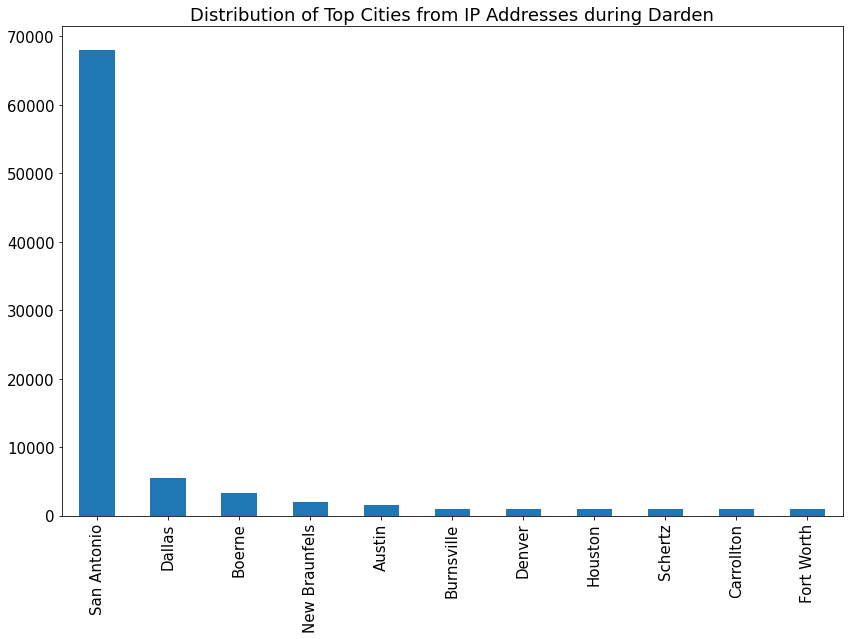

In [33]:
city_plot_df['city'].value_counts().plot(kind='bar')
plt.title('Distribution of Top Cities from IP Addresses during Darden')
plt.show()

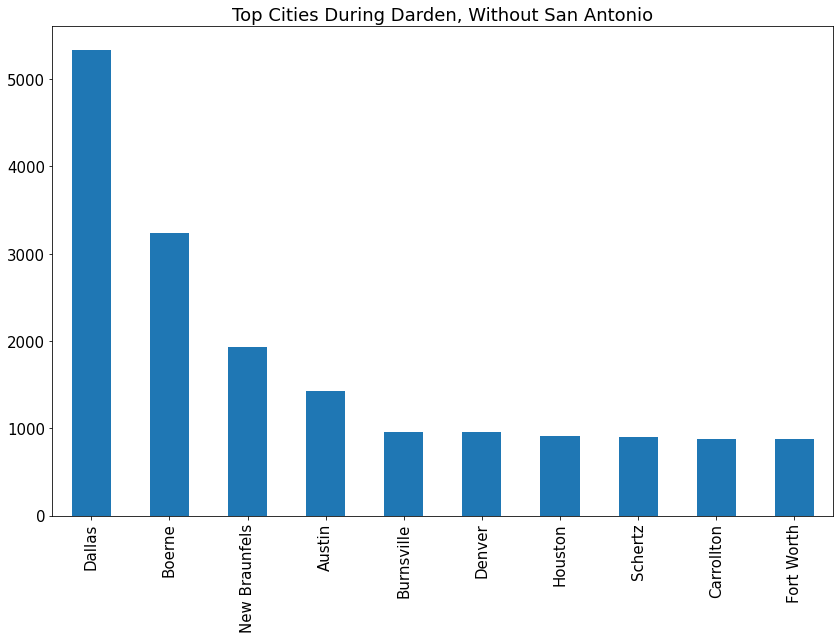

In [34]:
city_plot_df['city'].drop(city_plot_df[city_plot_df.city == 'San Antonio'].index).value_counts().plot(kind='bar')
plt.title('Top Cities During Darden, Without San Antonio')
plt.show()

In [86]:
city_plot_anomalies = darden_df.groupby('city').filter(lambda x : len(x)<4)
city_plot_anomalies.city.nunique()

20

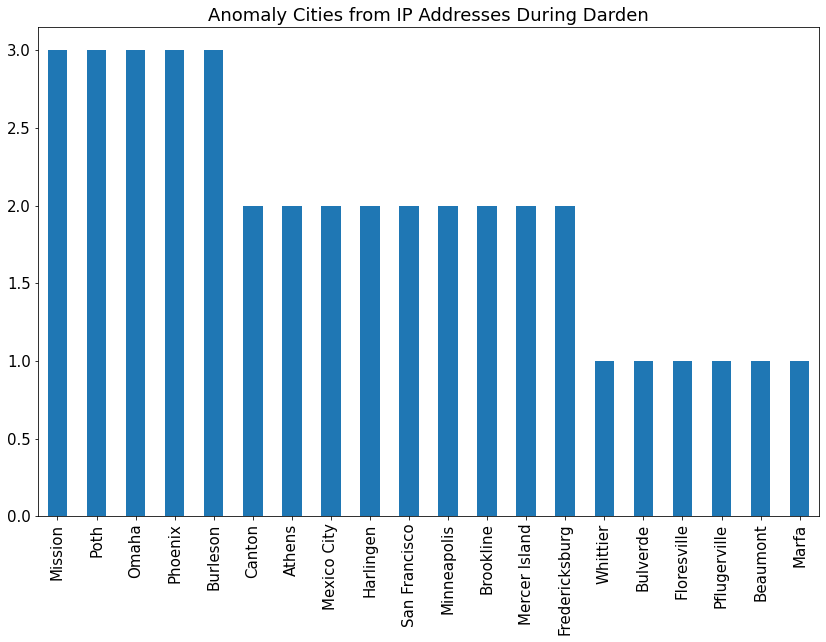

In [87]:
city_plot_anomalies['city'].value_counts().plot(kind='bar')
plt.title('Anomaly Cities from IP Addresses During Darden')
plt.show()

**Takeaways:** Mexico City showed up (it seems GeoLite couldn't acquire the city in some places and gave me the country instead), so I'm going to see if I can zoom in on geolocations from outside the USA.

**Create Country feature**

Note: Still working with just the Darden duration data so that my geolocation code isn't too computationally expensive.

In [37]:
def add_country(ip):
    try:
        response = reader.city(ip)
        country_name = response.country.name
        return country_name
    except:
        return np.nan

In [38]:
darden_df['country'] = darden_df.apply(lambda darden_df: add_country(darden_df['ip']),axis=1)

In [88]:
darden_df.country.nunique()
darden_df.country.value_counts()
country_plot_df = darden_df.groupby('country').filter(lambda x : len(x)>700)
country_plot_df.country.nunique()

1

In [40]:
darden_df.head()

,request_method,user_id,cohort_id,ip,network,host,city,country
ds,,,,,,,,
2020-07-13 00:00:19,appendix,633,57,24.26.242.224,2426,242224,San Antonio,United States
2020-07-13 00:00:23,appendix/professional-development/linkedin-tips,633,57,24.26.242.224,2426,242224,San Antonio,United States
2020-07-13 00:04:59,appendix/professional-development/cover-letter,614,56,174.67.1.123,17467,1123,Oklahoma City,United States
2020-07-13 00:05:49,spring/fundamentals/security/authentication,606,56,76.187.7.114,76187,7114,Garland,United States
2020-07-13 00:52:09,javascript-i/arrays,672,58,67.11.50.23,6711,5023,Boerne,United States


**Look for Suspicious IPs in the City and Country NaNs**

It's possible that the city for some IP addresses was unable to be acquired because of suspicious reasons. 

There are hits from Germany, U.S. Virgin Islands, and Mexico.

Let's investigate.

Reference: https://ipremoval.sms.symantec.com/ipr/lookup

I tested the reference with my own IP address for a quick check of it's validity, and it came back with "no bad reputation" for my IP address.

In [41]:
darden_df[darden_df.country != 'United States'].country.value_counts()

Germany                81
U.S. Virgin Islands     4
Mexico                  2
Name: country, dtype: int64

In [42]:
darden_df[darden_df.country == 'Germany'].ip.value_counts()

79.220.63.16      62
87.158.135.133    19
Name: ip, dtype: int64

> The IP Address 79.220.63.16 was found to have a negative reputation. Reasons for this assessment include:
> * The host has been observed sending spam in a format that is similar to snow shoe spamming techniques.
> * The host is unauthorized to send email directly to email servers.

> The IP Address 87.158.135.133 was found to have a negative reputation. Reasons for this assessment include:
> * The host has been observed sending spam in a format that is similar to snow shoe spamming techniques.
> * The host is unauthorized to send email directly to email servers.

**Create bad IPs dataframe**

In [43]:
#add these to bad ips df
bad_ips = darden_df[(darden_df.ip == '79.220.63.16') | 
                    (darden_df.ip == '79.220.63.16')]
bad_ips

,request_method,user_id,cohort_id,ip,network,host,city,country
ds,,,,,,,,
2020-10-05 09:02:56,javascript-ii,12,22,79.220.63.16,79220,6316,Munich,Germany
2020-10-05 09:03:04,javascript-i,12,22,79.220.63.16,79220,6316,Munich,Germany
2020-10-05 09:03:08,javascript-i/introduction,12,22,79.220.63.16,79220,6316,Munich,Germany
2020-10-05 09:03:12,javascript-i/introduction/primitive-types,12,22,79.220.63.16,79220,6316,Munich,Germany
2020-10-05 09:03:16,javascript-i/introduction/operators,12,22,79.220.63.16,79220,6316,Munich,Germany
...,...,...,...,...,...,...,...,...
2020-10-05 09:08:16,java-ii/file-io,12,22,79.220.63.16,79220,6316,Munich,Germany
2020-10-05 09:08:19,java-ii/dependency-management,12,22,79.220.63.16,79220,6316,Munich,Germany
2020-10-05 09:08:24,java-ii/junit-tdd,12,22,79.220.63.16,79220,6316,Munich,Germany


In [44]:
darden_df.isna().sum()

request_method      0
user_id             0
cohort_id           0
ip                  0
network             0
host                0
city              185
country             0
dtype: int64

In [45]:
darden_df[darden_df.city.isna()]

,request_method,user_id,cohort_id,ip,network,host,city,country
ds,,,,,,,,
2020-07-13 10:14:49,spring/fundamentals/views,615,56,107.242.125.32,107242,12532,None,United States
2020-07-13 11:19:32,html-css/elements,615,56,107.242.125.32,107242,12532,None,United States
2020-07-13 11:19:46,html-css/forms,615,56,107.242.125.32,107242,12532,None,United States
2020-07-13 11:20:03,html-css/css-i,615,56,107.242.125.32,107242,12532,None,United States
2020-07-13 11:20:04,html-css/css-i/introduction,615,56,107.242.125.32,107242,12532,None,United States
...,...,...,...,...,...,...,...,...
2020-11-02 13:33:07,jquery,769,62,98.39.66.72,9839,6672,None,United States
2020-11-02 13:33:12,javascript-i,769,62,98.39.66.72,9839,6672,None,United States
2020-11-02 13:33:16,javascript-i/bom-and-dom,769,62,98.39.66.72,9839,6672,None,United States


**Takeaways:** Using https://ipremoval.sms.symantec.com/ipr/lookup, I searched for ```107.242.125.32``` and it returned:

>The IP Address 107.242.125.32 was found to have a negative reputation. Reasons for this assessment include:
>* The host has been observed sending spam in a format that is similar to snow shoe spamming techniques.
>* The host is unauthorized to send email directly to email servers.

I ran IP address ```98.39.66.72``` as well, but it did not have any bad reputation.

Regardless, I see that both of those IP addresses seem to hit each page quickly, in succession.

**I can conclude that these two IP addresses are scrapper bots.**

The scrapper bots seem to maybe be scrapping the Web Dev curriculum more than the Data Science curriculum, so I'm going to run a hypothesis test to test that. However, first I need to prepare the data for the test.

In [46]:
darden_df[darden_df.city.isna()].ip.value_counts()

107.242.125.32     26
98.39.66.72        22
107.77.201.165     21
174.128.181.39     19
170.130.2.251      16
31.13.189.90        9
107.152.98.82       8
174.246.201.223     8
12.31.71.58         7
107.242.125.50      7
107.242.125.38      5
208.30.107.160      4
206.214.78.211      4
174.246.196.212     4
174.255.132.117     4
107.158.15.51       3
3.209.254.178       3
176.113.73.30       3
72.173.98.235       2
107.242.125.63      2
206.214.78.35       2
107.158.15.59       1
174.128.180.196     1
107.77.201.226      1
107.77.201.138      1
174.244.67.71       1
107.242.125.44      1
Name: ip, dtype: int64

I've also found that ```107.77.201.165```, ```174.128.181.39```, ```170.130.2.251```, ```174.246.201.223```,  have bad reputations according to the search as well.

I wonder if 107 at the beginning of an IP address means something important.

For ```170.130.2.251```, ```31.13.189.90```, ```107.152.98.82``` the search results included another reason for the bad reputation - snow shoe spamming.

Turn out that ```12.31.71.58 ```, ```206.214.78.35``` and ```3.209.254.178 ``` are not even valid IPv4 addresses.

Now that's enough manual lookup. Time to move on. I'll just store my proven suspicious IPs in a new dataframe named ```bad_ips```.

**Add to bad IPs dataframe**

In [47]:
test_df = bad_ips
bad_ips_append = darden_df[(darden_df.ip == '107.77.201.165') | 
                    (darden_df.ip == '174.128.181.39') | 
                    (darden_df.ip == '170.130.2.251') | 
                    (darden_df.ip == '174.246.201.223') | 
                    (darden_df.ip == '170.130.2.251') | 
                    (darden_df.ip == '31.13.189.90') | 
                    (darden_df.ip == '107.152.98.82')]
result = pd.merge(test_df, bad_ips_append, how='inner')
result

,request_method,user_id,cohort_id,ip,network,host,city,country


**Prepare data for hypothesis test**

### Hypothesis 1:
    
>**note to self:**
>compare darden and whatever cohort of web dev overlaps with us (resample for web dev, and use ryan's string contains code for both to seperate them out)
>
>make a hypothesis about their locations, perhaps, maybe about which one is more likely to have suspicious locations and go into reasons why behind that

### Explore request_methods

**Plot distributions of request_methods by user**

In [48]:
darden_df.groupby('request_method')

In [49]:
darden_df.groupby(['request_method']).filter(lambda x : len(x)>7100)

,request_method,user_id,cohort_id,ip,network,host,city,country
ds,,,,,,,,


## For fun... where am I?

In [50]:
kwame_df = df[df.ip == '99.132.128.255']
kwame_df

,request_method,user_id,cohort_id,ip,network,host
ds,,,,,,
2020-07-14 16:08:28,1-fundamentals/1.3-pipeline-demo,687,59,99.132.128.255,99132,128255
2020-07-14 16:09:31,1-fundamentals/1.1-intro-to-data-science,687,59,99.132.128.255,99132,128255
2020-07-14 16:09:32,1-fundamentals/modern-data-scientist.jpg,687,59,99.132.128.255,99132,128255
2020-07-14 16:09:32,1-fundamentals/AI-ML-DL-timeline.jpg,687,59,99.132.128.255,99132,128255
2020-07-14 16:32:47,1-fundamentals/1.2-data-science-pipeline,687,59,99.132.128.255,99132,128255
...,...,...,...,...,...,...
2020-10-31 16:45:54,timeseries/modeling-lesson1,780,59,99.132.128.255,99132,128255
2020-11-02 09:21:45,anomaly-detection/overview,780,59,99.132.128.255,99132,128255
2020-11-02 09:21:45,anomaly-detection/AnomalyDetectionCartoon.jpeg,780,59,99.132.128.255,99132,128255


In [89]:
darden_students = df[df.cohort_id == '59']
darden_students

,request_method,cohort_id,ip,network,host
ds,,,,,
2020-07-13 14:39:21,13-advanced-topics/1-tidy-data,59,24.28.146.155,2428,146155
2020-07-13 14:39:36,1-fundamentals/1.1-intro-to-data-science,59,24.28.146.155,2428,146155
2020-07-13 14:39:37,1-fundamentals/AI-ML-DL-timeline.jpg,59,24.28.146.155,2428,146155
2020-07-13 14:39:37,1-fundamentals/modern-data-scientist.jpg,59,24.28.146.155,2428,146155
2020-07-13 14:39:53,1-fundamentals/1.1-intro-to-data-science,59,108.239.188.205,108239,188205
...,...,...,...,...,...
2020-11-02 15:47:59,appendix/useful_libraries,59,24.28.150.196,2428,150196
2020-11-02 15:48:03,appendix/ds-environment-setup,59,24.28.150.196,2428,150196
2020-11-02 15:48:14,appendix/interview_questions_students,59,24.28.150.196,2428,150196


In [90]:
darden_students['city'] = darden_students.apply(lambda darden_students: add_city(darden_students['ip']),axis=1)

In [91]:
darden_students.city.value_counts()

San Antonio      16831
Burnsville         986
Austin             899
Boerne             788
Houston            411
Helotes            111
Converse            55
Marble Falls        48
Hondo               37
Dallas              20
Port Aransas        20
Raleigh             17
New Braunfels       16
Killeen              7
Cibolo               6
Phoenix              3
Omaha                3
Minneapolis          2
Harlingen            2
Marfa                1
Beaumont             1
Tulsa                1
Name: city, dtype: int64

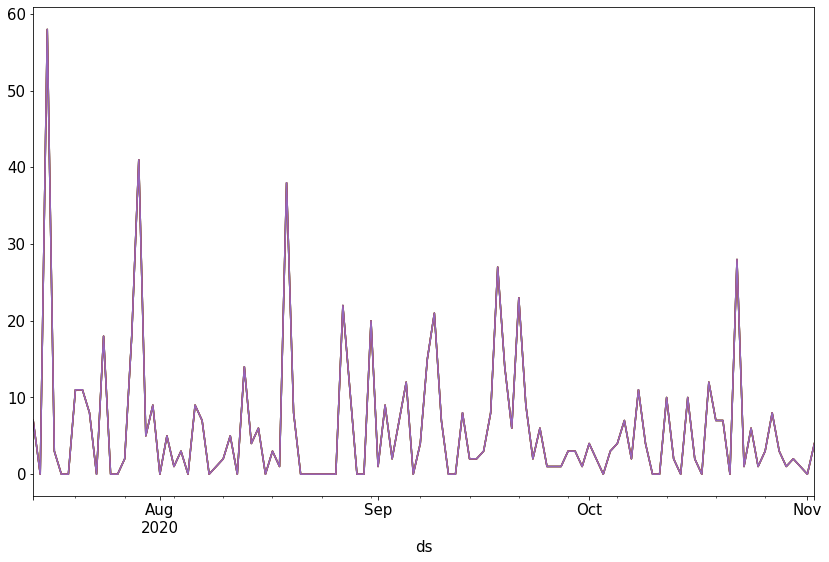

In [79]:
kwame_df.resample('D').count().plot(legend=False)

In [95]:
response = reader.city('99.132.128.255')
print(response.location.latitude)
print(response.location.longitude)

29.4059
-98.5078


In [94]:
#kwame_df.resample('4D').count().plot(legend=False)

In [93]:
#kwame_df.drop(columns=['cohort_id', 'ip', 'network', 'host'])

In [92]:
#kwame_df.drop(columns=['cohort_id', 'ip', 'network', 'host']).groupby(['ds'])['request_method'].value_counts().plot()

### Slice data by cohort/program

In [97]:
#program_id == 2
web_dev = df[(df.cohort_id == '15') | 
             (df.cohort_id == '16') | 
             (df.cohort_id == '18') | 
             (df.cohort_id == '20') | 
             (df.cohort_id == '21') | 
             (df.cohort_id == '22') | 
             (df.cohort_id == '23') | 
             (df.cohort_id == '24') | 
             (df.cohort_id == '25') | 
             (df.cohort_id == '26') | 
             (df.cohort_id == '27') | 
             (df.cohort_id == '28') | 
             (df.cohort_id == '29') | 
             (df.cohort_id == '31') | 
             (df.cohort_id == '32') | 
             (df.cohort_id == '33') | 
             (df.cohort_id == '51') | 
             (df.cohort_id == '52') | 
             (df.cohort_id == '53') | 
             (df.cohort_id == '56') | 
             (df.cohort_id == '57') | 
             (df.cohort_id == '58') | 
             (df.cohort_id == '60') | 
             (df.cohort_id == '61') | 
             (df.cohort_id == '62') | 
             (df.cohort_id == '132')]

#program_id == 3
data_science = df[(df.cohort_id == '30') | 
                  (df.cohort_id == '34') | 
                  (df.cohort_id == '55') | 
                  (df.cohort_id == '59')]

### Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [101]:
data_science.request_method.value_counts()

1-fundamentals/modern-data-scientist.jpg    1559
1-fundamentals/AI-ML-DL-timeline.jpg        1553
1-fundamentals/1.1-intro-to-data-science    1530
search/search_index.json                    1329
6-regression/1-overview                     1122
                                            ... 
regression/least-angle-regression              1
java-ii/object-oriented-programming            1
9-timeseries/6.1-parametric-modeling           1
bad-charts                                     1
capstones                                      1
Name: request_method, Length: 595, dtype: int64

**Takeaway:** The most popular lesson for Data Science cohorts is Fundamentals (1.1): Intro to Data Science. Second to that is Regression: Overview.

In [102]:
web_dev.request_method.value_counts()

toc                                                 13161
javascript-i                                        13112
search/search_index.json                            12107
java-iii                                            10083
html-css                                             9768
                                                    ...  
quiz115                                                 1
4-stats/2.5-distributions-and-testing                   1
fundamentals/cli/file-paths                             1
uploads/58a217a705bde.jpg                               1
content/examples/html/gitbook/images/favicon.ico        1
Name: request_method, Length: 1798, dtype: int64

**Takeaway:** The most popular lesson for Web Dev cohorts is TOC (not sure if that's actually a lesson or not), which has just a handful of hits more than the second most popular lesson, Javascript I.

### Is there a cohort that referred to a lesson significantly more that other cohorts seemed to gloss over? 

In [123]:
# data science cohorts
cohorts = ['30', '34', '55', '59']
for cohort in cohorts:
    print('Five most popular lessons in cohort', cohort + ':\n')
    print(data_science[data_science.cohort_id == cohort].request_method.value_counts().head(5))
    print('\n---\n')

Five most popular lessons in cohort 30:

Series([], Name: request_method, dtype: int64)

---

Five most popular lessons in cohort 34:

1-fundamentals/modern-data-scientist.jpg    625
1-fundamentals/AI-ML-DL-timeline.jpg        623
1-fundamentals/1.1-intro-to-data-science    613
search/search_index.json                    550
6-regression/1-overview                     521
Name: request_method, dtype: int64

---

Five most popular lessons in cohort 55:

6-regression/1-overview                     594
search/search_index.json                    479
1-fundamentals/modern-data-scientist.jpg    467
1-fundamentals/AI-ML-DL-timeline.jpg        464
1-fundamentals/1.1-intro-to-data-science    460
Name: request_method, dtype: int64

---

Five most popular lessons in cohort 59:

classification/overview                     756
classification/scale_features_or_not.svg    587
sql/mysql-overview                          510
1-fundamentals/modern-data-scientist.jpg    467
1-fundamentals/AI-ML-DL-timel

Cohort 30 (Ada) seems to not have accessed this curriculum, or the information is missing.

Bayes' most popular lessons were in Fundamentals and Regression.

Curie's were Regression and Fundamentals (in that order).

Darden's are (so far) Classification, SQL, and Fundamentals.


**Takeaways:** Everyone looks at fundamentals a lot, Curie and Bayes both look at Regression a lot, and Darden is a bit different. We also use the search feature relatively less than previous cohorts.

### Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students? 